In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array 
import PIL 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model,Sequential, model_from_json
from keras.initializers import glorot_uniform
import cv2
import dlib
from PIL import Imagea
from skimage import transform
from sklearn.model_selection import train_test_split 
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.regularizers import l2
from keras.optimizers import Adam
import json
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [24]:
print(df.groupby('emotion').agg('count'))
df.drop(df[df['emotion']==1].index, inplace=True)
print(df.groupby('emotion').agg('count'))   

pixels
emotion        
0          3995
1           436
2          4097
3          7215
4          4830
5          3171
6          4965
         pixels
emotion        
0          3995
2          4097
3          7215
4          4830
5          3171
6          4965


In [2]:
df = pd.read_csv("train.csv")
datapoints = df['pixels'].tolist()
X_train = []
for x in datapoints:
    X = [int(i) for i in x.split(' ')]
    X = np.asarray(X).reshape(48,48)
    X_train.append(X.astype('float32'))
X_train = np.asarray(X_train)
X_train = np.expand_dims(X_train,-1)
Y_train = pd.get_dummies(df['emotion']).as_matrix()   

[0 0 0 0 0 0 1]


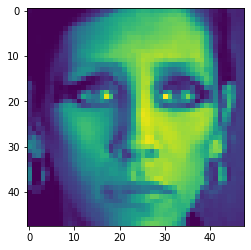

In [5]:
x = X_train[4]
x = x.reshape((48,48))
plt.imshow(x)
print(Y_train[4])

In [6]:
X_train/=255.0
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)                           

In [7]:
print("Train Shape : {}".format(X_train.shape))
print("Train Shape : {}".format(Y_train.shape))
print("Valid Shape : {}".format(X_valid.shape))
print("Valid Shape : {}".format(Y_valid.shape))

Train Shape : (25838, 48, 48, 1)
Train Shape : (25838, 7)
Valid Shape : (2871, 48, 48, 1)
Valid Shape : (2871, 7)


In [8]:
def model_arch() :
    input_X = Input((48,48,1))
    # START
    conv_1 = Conv2D(64,(7,7),strides=(2,2),activation='relu')(input_X)
    pool_1 = MaxPooling2D((3,3),strides=(2,2))(conv_1)
    lrn_1 = keras.layers.BatchNormalization()(pool_1)

    #FEAT-EX1
    conv_2a = Conv2D(96,(1,1),strides=(1,1),activation='relu')(lrn_1)
    conv_2b = Conv2D(208,(1,1),strides=(1,1),activation='relu')(conv_2a)
    pool_2a = MaxPooling2D((3,3),strides=(1,1),padding='same')(lrn_1)
    conv_2c = Conv2D(64,(1,1),strides=(1,1),activation='relu')(pool_2a)
    concat2 = keras.layers.concatenate(inputs=[conv_2b,conv_2c], axis=3)
    pool_2b = MaxPooling2D((3,3),strides=(2,2))(concat2)

    #FEAT-X2
    conv_3a = Conv2D(96,(1,1),strides=(1,1),activation='relu')(pool_2b)
    conv_3b = Conv2D(96,(1,1),strides=(1,1),activation='relu')(conv_3a)
    pool_3a = MaxPooling2D((3,3),strides=(1,1),padding='same')(pool_2b)
    conv_3c  = Conv2D(64,(1,1),strides=(1,1),activation='relu')(pool_3a)
    concat3 = keras.layers.concatenate(inputs=[conv_3c,conv_3b], axis=3)
    pool_3b = MaxPooling2D((3,3),strides=(2,2))(concat3)

    out = Flatten()(pool_3b)
    out = Dense(7,activation='softmax')(out)

    model = Model(inputs=input_X, outputs = out)

    return model




In [51]:
def model_arch() :
    input1 = Input((48,48,1))
    X = Conv2D(32,(5,5),strides=(2,2),padding = 'same',data_format='channels_last',activation='relu')(input1)
    X = Conv2D(64,(5,5),strides=(2,2),padding = 'same', activation='relu')(X)
    block_1_out = MaxPooling2D((2,2))(X)

    X = Conv2D(64,(5,5),padding = 'same',data_format='channels_last',activation='relu')(block_1_out)
    X = Conv2D(128,(5,5),padding = 'same')(X)
    block_1_out = Conv2D(128,(1,1),padding='same',activation='relu')(block_1_out)
    block_2_out = Add()([X,block_1_out])
    block_2_out = Activation('relu')(block_2_out)
    block_2_temp = MaxPooling2D((2,2))(block_2_out)

    X = Conv2D(128,(3,3),strides=(2,2),padding = 'same',data_format='channels_last',activation='relu')(block_2_out)
    X = Conv2D(256,(3,3),padding = 'same')(X)
    block_2_out = Conv2D(256,(1,1),padding='same')(block_2_temp)
    block_3_out = Add()([X,block_2_out])
    block_3_out = Activation('relu')(block_3_out)

    X = Conv2D(256,(3,3),padding = 'same',data_format='channels_last',activation='relu')(block_3_out)
    X = Conv2D(512,(3,3),padding = 'same')(X)
    block_3_out = Conv2D(512,(1,1),padding='same')(X)
    block_4_out = Add()([X,block_3_out])
    block_4_out = Activation('relu')(block_4_out)

    X = Conv2D(1024,(3,3),strides=(2,2), padding='same',activation='relu')(block_4_out)
    X = Dropout(0.1)(X)
    X = MaxPooling2D((2,2))(X)
    X = Flatten()(X)
    X = Dense(2048,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(1024,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(512,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(7,activation = 'softmax')(X)
    X = Model(inputs = input1, outputs = X)
    return X

In [9]:
def get_compiled_model():
    model = model_arch()
    model.compile(optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model


In [10]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train,Y_train,batch_size=64)
valid_generator = valid_datagen.flow(X_valid,Y_valid,batch_size=1)

In [11]:
model = get_compiled_model()
# model = load_model('model_early1.h5')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='model2/model_{epoch}_{val_loss}.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.9, patience = 3)
]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# print(STEP_SIZE_TRAIN,train_generator.n,train_generator.batch_size)
# print(STEP_SIZE_VALID,valid_generator.n,valid_generator.batch_size)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs=100,
    validation_data = valid_generator,
    validation_steps = STEP_SIZE_VALID,
    callbacks=callbacks
)

403/403 [==============================] - 17s 42ms/step - loss: 1.7000 - accuracy: 0.3118 - val_loss: 1.9600 - val_accuracy: 0.3002

Epoch 00002: val_loss did not improve from 1.45519
Epoch 3/100
403/403 [==============================] - 18s 44ms/step - loss: 1.6431 - accuracy: 0.3459 - val_loss: 1.9122 - val_accuracy: 0.1898

Epoch 00003: val_loss did not improve from 1.45519
Epoch 4/100
403/403 [==============================] - 17s 41ms/step - loss: 1.5869 - accuracy: 0.3729 - val_loss: 1.2007 - val_accuracy: 0.3013

Epoch 00004: val_loss improved from 1.45519 to 1.20073, saving model to model2/model_4_1.2007311582565308.h5
Epoch 5/100
403/403 [==============================] - 18s 44ms/step - loss: 1.5451 - accuracy: 0.3971 - val_loss: 0.7506 - val_accuracy: 0.3581

Epoch 00005: val_loss improved from 1.20073 to 0.75057, saving model to model2/model_5_0.7505709528923035.h5
Epoch 6/100
403/403 [==============================] - 16s 40ms/step - loss: 1.5177 - accuracy: 0.4121 - val

In [12]:
model.save('model_feat2.h5')

In [13]:
json_string = model.to_json()
# print(json_string)
with open("model_feat2.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('model_feat2_weights.h5')

In [46]:
model = load_model('model2\model_80_0.007265218999236822.h5')

In [21]:
json_file = open('model_best.json', 'r')
loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
json_file.close()
model.load_weights("model_best_weights.h5")
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")

(445, 300, 3)
[4]


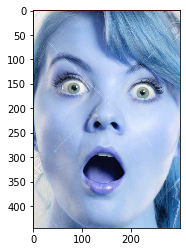

In [47]:
frame = cv2.imread('testImages/d2.jpg')
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# print(frame.shape)
(h,w) = frame.shape[:2]  
blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300,300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
net.setInput(blob)
detections = net.forward()
# print(detections.shape)
m=0
for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence < 0.5:
        continue    
    if(m < confidence):
        m = confidence
        pos = i       
        box = detections[0, 0, pos, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        image = frame[startY:endY, startX:endX]
        # plt.imshow(image)
cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 2)
cv2.imwrite('3.jpg',frame)
print(image.shape)
plt.imshow(image)
face = cv2.cvtColor(cv2.resize(image,(48,48)), cv2.COLOR_BGR2GRAY)
roi = face.astype("float")
roi-=np.mean(roi,axis=0)
roi/=np.std(roi,axis=0)
roi = np.reshape(roi,(1,48,48,1))
# print(roi.shape)
# image = cv2.reshape(image,(1,48,48,1))    
pred = model.predict(roi)
# print(pred)
c = list(np.argmax(pred,axis=1))
print(c)
# pred = model.predict(image)
# c = list(np.argmax(pred,axis=1))
# print(c)


In [20]:
realtime()